# PACE OOD UMAP

In [2]:
# imports
from importlib import reload
import numpy as np
import os

import h5py
import xarray

from scipy.spatial import Delaunay
from sklearn import decomposition
import umap

from matplotlib import pyplot as plt

from oceancolor.pace import io as pace_io
from oceancolor.hydrolight import loisel23
from oceancolor.utils import spectra
from oceancolor.utils import pca

# Load

## PACE

In [3]:
ex_pace_file = os.path.join(os.getenv('OS_COLOR'),
                       'data', 'PACE', 'early',
                       'PACE_OCI.20240416T093158.L2.OC_AOP.V1_0_0.NRT.nc')

In [4]:
pace_xds, flags = pace_io.load_oci_l2(ex_pace_file)

## Loisel+2023

In [5]:
X, Y = 4, 0
l23_ds = loisel23.load_ds(X, Y)

In [6]:
l23_ds.Lambda.data

array([350., 355., 360., 365., 370., 375., 380., 385., 390., 395., 400.,
       405., 410., 415., 420., 425., 430., 435., 440., 445., 450., 455.,
       460., 465., 470., 475., 480., 485., 490., 495., 500., 505., 510.,
       515., 520., 525., 530., 535., 540., 545., 550., 555., 560., 565.,
       570., 575., 580., 585., 590., 595., 600., 605., 610., 615., 620.,
       625., 630., 635., 640., 645., 650., 655., 660., 665., 670., 675.,
       680., 685., 690., 695., 700., 705., 710., 715., 720., 725., 730.,
       735., 740., 745., 750.], dtype=float32)

In [7]:
l23_Rrs = l23_ds.Rrs.data
l23_Rrs.shape

(3320, 81)

# Pre-Process

## PACE

### Grab the ok set

In [8]:
pace_keep = flags == 0

In [9]:
pace_Rrs = pace_xds.Rrs.data[pace_keep]

In [10]:
pace_Rrs.shape

(506051, 184)

## Cut down wavelengths

In [11]:
min_wv = 400.
gd_wave = (pace_xds.wavelength >= min_wv)
pace_wave = pace_xds.wavelength[gd_wave]

In [12]:
pace_Rrs = pace_Rrs[:, gd_wave]

In [13]:
pace_Rrs.shape

(506051, 159)

## L23

## Rebin to PACE wavelengths

In [14]:
#wave_bins = (np.roll(pace_wave,-1) + pace_wave)/2.
## Edge
#wave_bins[-1] = pace_wave[-1] + (pace_wave[-1]-pace_wave[-2])/2.
#wave0 = pace_wave[0] - (pace_wave[1]-pace_wave[0])/2.
## Add the first
#wave_bins = np.append([wave0], wave_bins)
#wave_bins

In [15]:
l23_Rrs.shape

(3320, 81)

In [16]:
rebin_l23 = np.zeros((l23_Rrs.shape[0], pace_wave.size))

In [17]:
#
for kk in range(rebin_l23.shape[0]):
    rebin_l23[kk,:], _ = spectra.rebin(l23_ds.Lambda.data, l23_Rrs[kk], pace_wave)

## UMAP L23

In [18]:
reducer_umap = umap.UMAP(random_state=42)
latents_mapping = reducer_umap.fit(rebin_l23)

/home/xavier/miniconda3/envs/os_11/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


# Embed

In [19]:
l23_embedding = latents_mapping.transform(rebin_l23)

In [20]:
pace_embedding = latents_mapping.transform(pace_Rrs[:20000,:])

# Plot

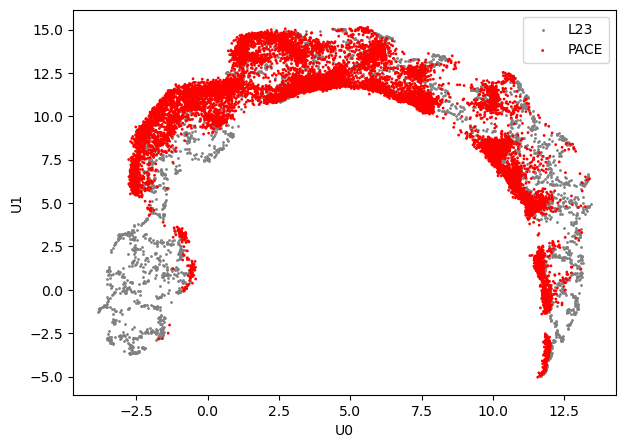

In [22]:
fig = plt.figure(figsize=(7,5))

plt.clf()
ax = plt.gca()
ax.scatter(l23_embedding[:,0], l23_embedding[:,1], color='gray', label='L23', s=1)
ax.scatter(pace_embedding[:,0], pace_embedding[:,1], facecolor='None', edgecolor='red', label='PACE', s=1)
#
ax.set_xlabel('U0')
ax.set_ylabel('U1')
ax.legend()
#
plt.show()